# Random Forest and MLP Models

Import required packages and modules.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

Load the prepared data from the SQLite database.

In [2]:
conn = sqlite3.connect('cleaned_customer_support.db')
data = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)
conn.close()

Define target variable `y`.

In [3]:
y = data['CSAT_Score'].astype('category')  # Ensuring 'y' is a categorical type for stratification

Prepare the data using one-hot encoder to convert categorical features into numerical features and combine them.

In [4]:
# OneHotEncode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(
    data[['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager']])
encoded_feature_names = encoder.get_feature_names_out(
    ['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager'])

# Combine numerical and OneHotEncoded categorical features
X = pd.concat(
    [data[['issue_reported_hour_of_day', 'response_time_minutes', 'issue_reported_day_of_week', 'sentiment_score']],
     pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)], axis=1)

Split the data into training and testing sets with stratification

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Random Forest

Initialize hyperparameters and train Random Forest classifier

In [6]:
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train);

Get the best model from grid search then make predictions.

In [7]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

Plot confusion matrix

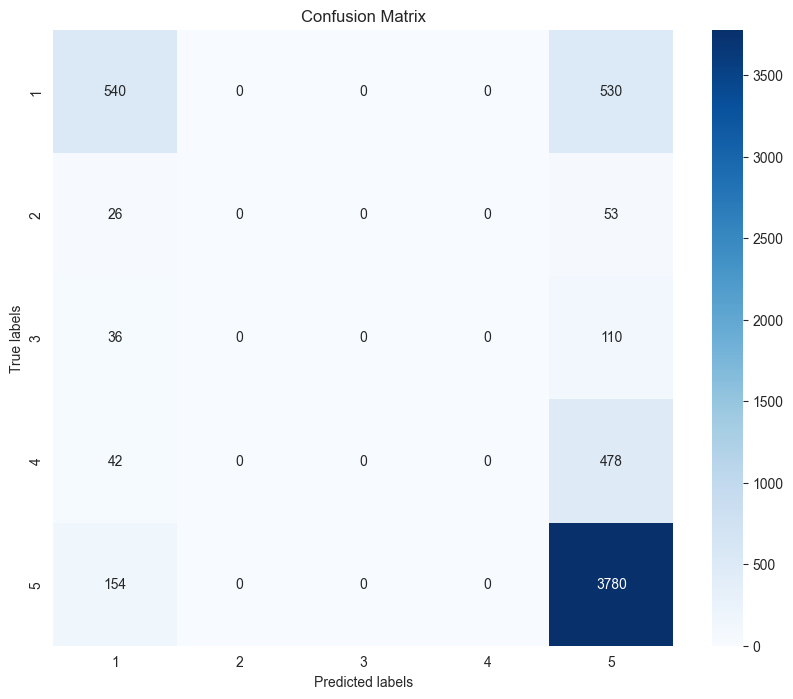

In [8]:
class_labels = [1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Display the best Random Forest model's classification report

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.50      0.58      1070
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00       146
           4       0.00      0.00      0.00       520
           5       0.76      0.96      0.85      3934

    accuracy                           0.75      5749
   macro avg       0.29      0.29      0.29      5749
weighted avg       0.65      0.75      0.69      5749


C:\Users\aspyr\Desktop\471-Project\pyvenv.cgf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aspyr\Desktop\471-Project\pyvenv.cgf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aspyr\Desktop\471-Project\pyvenv.cgf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Display top 5 most important features for best Random Forest model

In [10]:
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_indices[:5]]
top_importances = feature_importances[sorted_indices[:5]]

print("\nTop 5 Important Features for the Best Model:\n")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


Top 5 Important Features for the Best Model:

sentiment_score: 0.3756
response_time_minutes: 0.1390
issue_reported_hour_of_day: 0.0553
issue_reported_day_of_week: 0.0402
Sub-category_Return request: 0.0145


## Multi-Layered Perceptron

Define and train MLP classifier using set hyperparams.

In [11]:
param_grid = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500],
    'batch_size': [32, 64, 128],
    'early_stopping': [True], 
    'n_iter_no_change': [10],
}

grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train);

Make predictions with the best MLP model

In [12]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

Generate MLP classification report

In [13]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.62      0.53      0.57      1070
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00       146
           4       0.00      0.00      0.00       520
           5       0.77      0.95      0.85      3934

    accuracy                           0.75      5749
   macro avg       0.28      0.29      0.28      5749
weighted avg       0.64      0.75      0.69      5749


Plot confusion matrix

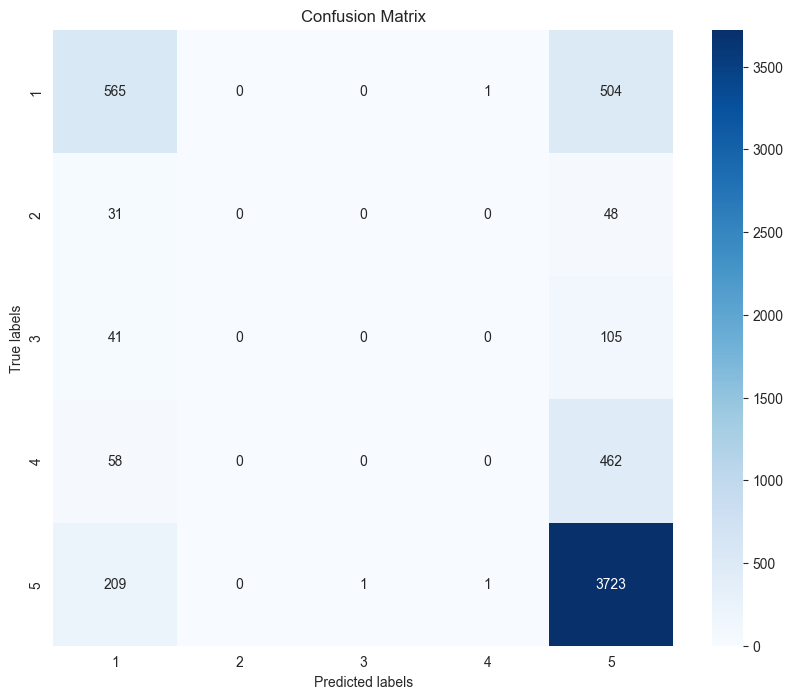

In [14]:
class_labels = y.cat.categories  # This will automatically extract the category labels

conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()